# Difference in Means Analysis on Light-outages and Crime
## Garrett Eason, Chris Broll, Shilpa Rajbhandari
*Note:* Most cleaning steps (the majority) have been omitted for simplicity.

In [ ]:
This project seeks to exploit a kind of natural experiment in the District of Columbia by examining crime in close proximity to street lights before and after they have been repaired.

The simplest analysis we can conceive is simply examining crime the week before and the week after a repair. This will require (1) goecoding the crime data; (2) geocoding lighting; (3) drawing some reasonable polygon -- perhaps a circle or perhaps a city block) around each light; (4) joining the lighting polygons with the crime data surrounding each light for the week prior to and following the repair. More sophisticated analyses will include standard statististical analyses and, possibly, machine learning analyses to predict where improved or upgraded lighting could do the most good.


In [19]:
#%% Packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

#%pylab notebook
#pylab.rcParams['figure.figsize'] = (12, 12)
%matplotlib notebook

#%% Locations
Windows = 'C:/Users/Sade/Documents/GitHub/lights-and-crime/Lights and Crime Garrett/Data'
Linux = '/home/sade/Desktop/Git Cloned Repos/lights-and-crime/Lights and Crime Garrett/Data'

choice = Windows

*Note:* make sure to point "choice" to the location of "Data" in repository on your computer.

## Basic EDA
### Data
Crimes - Data set about crimes.<br>
Lights - Data set about light outages.<br>
iSlims - Older data set containing information regarding public work (including light outages).<br>
fc - Data set containing failure codes for iSlims and City Work data.<br>

In [20]:
#%% EDA Data
Crimes = pd.read_excel(choice + '/crimes.xlsx')
iSlims = pd.read_excel(choice + '/iSlims_final.xlsx')
fc = pd.read_excel(choice + '/islims_failure_codes.xlsx')

### EDA iSlims
*Note:* EDA of CityWork data not done here, but the CityWork data is included in the analysis.

In [22]:
iSlims[['daysToComplete', 'daysLate']].describe()

,daysToComplete,daysLate
count,178337.000000,178337.000000
mean,2.064552,0.092875
std,2.366900,0.766011
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,3.000000,0.000000
max,23.000000,17.000000


On average it takes 2 days to complete a task and the completion of tasks are rarely late (excluding completion tasks beyond 14 days).


In [23]:
iSlims['ProblemID'].value_counts().head(5)

2      173121
13       1273
433       697
430       562
196       489
Name: ProblemID, dtype: int64

In [24]:
c = [2, 13, 433, 430, 196]
for i in range(len(fc)):
    if fc.loc[i,'failcodeID'] in c:
        print(str(fc.loc[i,'failcodeID']) + ' Description: ' +fc.loc[i, 'description'])

2 Description: (Light out)
13 Description: (No current)
196 Description: (Underpass light out)
430 Description: (DDOT Refer)
433 Description: (No Current to Over Head)


The vast majority of observation fail codes are lights going out as can be seen by the top 5 counts of failure codes.

<IPython.core.display.Javascript object>


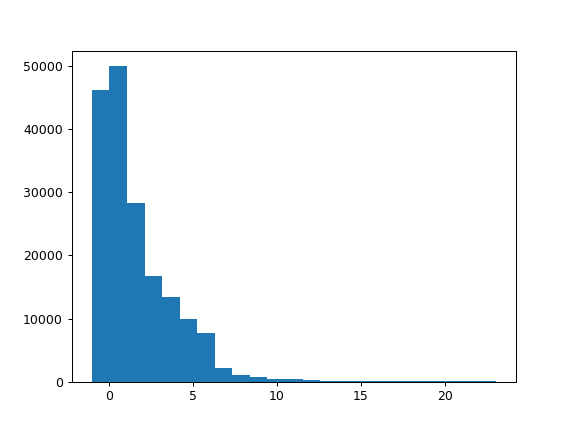

(array([46153., 49868., 28336., 16700., 13428.,  9860.,  7725.,  2182.,
         1089.,   668.,   439.,   365.,   319.,   188.,   189.,   183.,
          114.,   112.,    91.,    72.,    97.,    65.,    94.]),
 array([-1.        ,  0.04347826,  1.08695652,  2.13043478,  3.17391304,
         4.2173913 ,  5.26086957,  6.30434783,  7.34782609,  8.39130435,
         9.43478261, 10.47826087, 11.52173913, 12.56521739, 13.60869565,
        14.65217391, 15.69565217, 16.73913043, 17.7826087 , 18.82608696,
        19.86956522, 20.91304348, 21.95652174, 23.        ]),
 <a list of 23 Patch objects>)

In [27]:
plt.figure(1)
plt.hist(iSlims['daysToComplete'], bins = 23)

Histogram of the days it took to complete a work order.  As expected we can see a large drop off after 5 days.

<IPython.core.display.Javascript object>


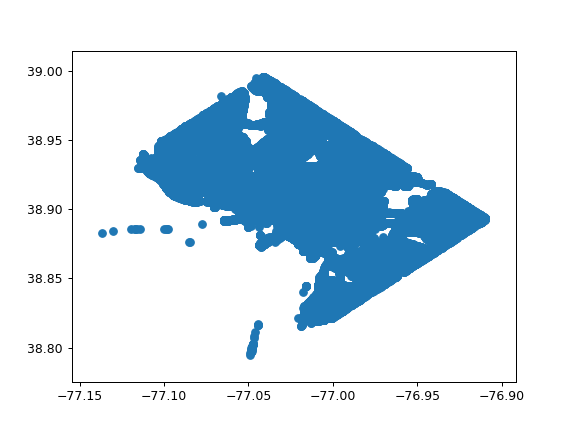

In [47]:
plt.figure(2)
plt.scatter(iSlims['gpsX'], iSlims['gpsY'])

As we can see it looks like the location data is plausible.

### EDA Crime

Taking a look at several variables in the Crimes data set:

In [30]:
Crimes[['SHIFT', 'METHOD', 'OFFENSE']].describe()
for i in ['SHIFT', 'METHOD', 'OFFENSE']:
    print(i + ':',Counter(Crimes[i]))

SHIFT: Counter({'EVENING': 120273, 'DAY': 108579, 'MIDNIGHT': 53042})
METHOD: Counter({'OTHERS': 256577, 'GUN': 16118, 'KNIFE': 9199})
OFFENSE: Counter({'THEFT/OTHER': 102156, 'THEFT F/AUTO': 82599, 'ROBBERY': 27559, 'BURGLARY': 24257, 'MOTOR VEHICLE THEFT': 23669, 'ASSAULT W/DANGEROUS WEAPON': 18311, 'SEX ABUSE': 2186, 'HOMICIDE': 942, 'ARSON': 215})


<IPython.core.display.Javascript object>


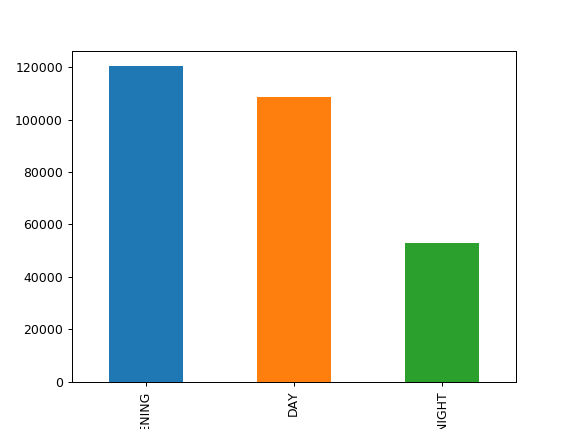

In [31]:
plt.figure(3)
Crimes['SHIFT'].value_counts().plot(kind='bar')

The fewest crimes take place during the "MIDNIGHT" shift.

<IPython.core.display.Javascript object>


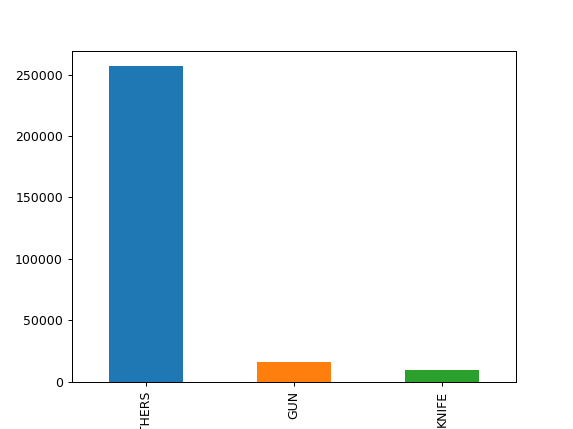

In [32]:
plt.figure(4)
Crimes['METHOD'].value_counts().plot(kind='bar')

<IPython.core.display.Javascript object>


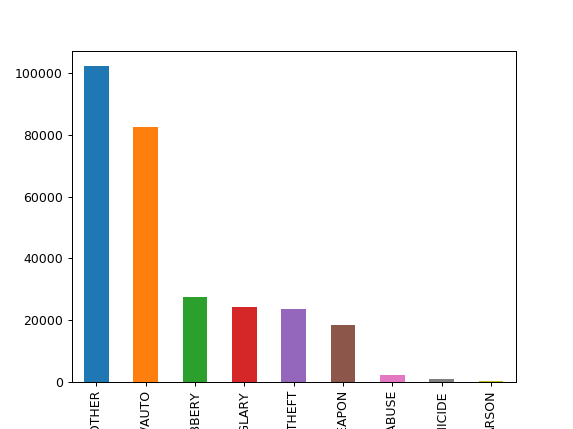

In [40]:
plt.figure(5)
Crimes['OFFENSE'].value_counts().plot(kind='bar')

Most crimes involve theft.

<IPython.core.display.Javascript object>


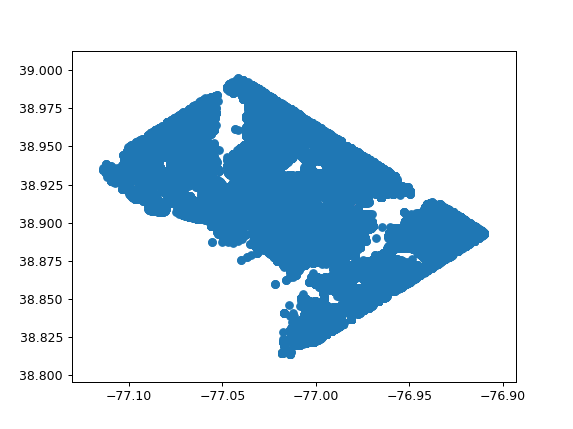

In [43]:
plt.figure(6)
plt.scatter(Crimes['X'], Crimes['Y'])

Again the Location data looks plausible.

<IPython.core.display.Javascript object>


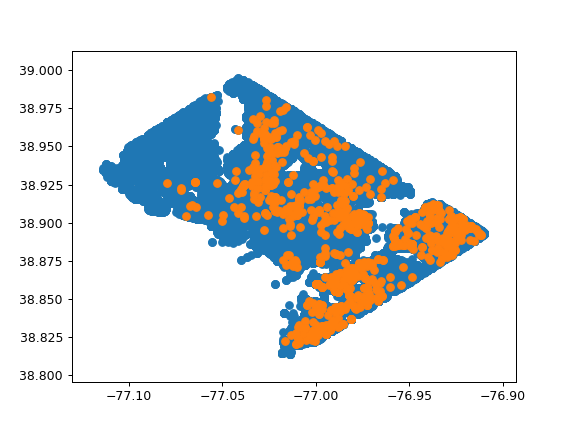

In [44]:
plt.figure(7)
plt.scatter(Crimes['X'], Crimes['Y'])
plt.scatter(Crimes[Crimes['OFFENSE'] == 'HOMICIDE']['X'], Crimes[Crimes['OFFENSE'] == 'HOMICIDE']['Y'])

Map of Homicides layed over all other criminal activities.  Homicides are disproportionately located on the Eastern side of DC.

## Final Data Cleaning
We start by loading our three main data sets, these include: "Lights.xlsx" - a data set with all the lightoutages (iSlims + CityWork data), "geoLights0.xlsx" - a data set that includes all the light-outages merged with crimes in a 1/4th block radius (1/2 a block diameter) that did not happen in a 20 day (10 days before repair and 10 days after repair) window, and "geoLights1.xlsx" - a data set that includes all the light-outages merged with crimes in a 1/4th block radius that did happen in a 20 day window.

After loading our data we do one final quick cleaning and manipulate our "geoLights1.xlsx" into two new data sets. For the "L_yesCR_dup_only" data set, we pull out all the instances of multiple crimes being mapped to a single street light outage. For the "L_yesCR_nodup" data set, we map all multiple instances.


In [46]:
L_full = pd.read_excel(choice + '/Final_Lights.xlsx')
L_yesCR_dup_only = pd.read_excel(choice + '/Rampage.xlsx')

## Analysis
*Note:* This analysis consists of a geojoin between crime data sets from 2010-2017 and both the iSlims data and CityWork data.<br>
Splitting the crimes into before and after 10 day categories (*Note:* 1 day buffer to avoid category errors):

In [48]:
L_full['CR_Before_Fix'] = 0
for i in L_full[L_full['Lightout&CR'] == 1].index:
    if (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days >= 0 and (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days <= 10:
        L_full.loc[i, 'CR_Before_Fix'] = 1
L_full['CR_After_Fix'] = 0
for i in L_full[L_full['Lightout&CR'] == 1].index:
    if (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days < 0 and (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days >= -10:
        L_full.loc[i, 'CR_After_Fix'] = 1

Total observed light outs tied with crimes out of our sample before the repair:

In [49]:
sum(L_full['CR_Before_Fix'])

4317

Total observed light outs tied with crimes out of our sample after the repair:

In [50]:
sum(L_full['CR_After_Fix'])

4007

Because we will only consider the binary crime(s) took place or not, we can consider the following means as differences in probabilities.<br>
Estimates are based on 10 "days out".<br>
Unconditional difference in means: E[u]-E[t]<br>

In [51]:
meandif = sum(L_full['CR_Before_Fix'])/len(L_full) - sum(L_full['CR_After_Fix'])/len(L_full)
meandif

0.0016992632871426078

Difference in Probability: approximately 0.17 percentage points

*Note:*<br>
<br>
For a Binary Random Variable:<br>
Var(x) = E[x^2] - E[x]^2<br>
        = E[x]   - E[x]^2, remember x = 1 or 0<br>
        = P(x = 1) - P(x = 1)^2<br>
        = P(x = 1)(1 - P(x = 1))<br>
<br>
For the sample standard deviation between two means:<br>
S(m1-m2) = sqrt([S1^2/n1] - [S2^2/n2])


In [52]:
VarB = sum(L_full['CR_Before_Fix'])/len(L_full)*(1 - sum(L_full['CR_Before_Fix'])/len(L_full))
VarA = sum(L_full['CR_After_Fix'])/len(L_full)*(1 - sum(L_full['CR_After_Fix'])/len(L_full))
Sdif = np.sqrt((VarB/len(L_full))+(VarA/len(L_full)))
t = meandif/Sdif
t


3.4372733186705053

P-value is approximately 0; estimate is statistically significant.<br>
This evidence supports the conculsion that light outages do affect crime generally by a very small margin unconditionally.<br>
Given the magnitude of our esitmate, it is likely that light outages do not effect crime.<br>

Conditional difference in means: E[u|'Lightout&CR' = 1] - E[t|'Lightout&CR' = 1]

In [53]:
meandif = sum(L_full['CR_Before_Fix'])/sum(L_full['Lightout&CR']) - sum(L_full['CR_After_Fix'])/sum(L_full['Lightout&CR'])
meandif

0.03535987224820347

Difference in Probability: approximately 3.5 percentage points

In [54]:
VarB = sum(L_full['CR_Before_Fix'])/sum(L_full['Lightout&CR'])*(1 - sum(L_full['CR_Before_Fix'])/sum(L_full['Lightout&CR']))
VarA = sum(L_full['CR_After_Fix'])/sum(L_full['Lightout&CR'])*(1 - sum(L_full['CR_After_Fix'])/sum(L_full['Lightout&CR']))
Sdif = np.sqrt((VarB/sum(L_full['Lightout&CR']))+(VarA/sum(L_full['Lightout&CR'])))
t = meandif/Sdif # t is approximately 4.69
t

4.691143451035653

P-value is approximately 0; estimate is statistically significant.<br>
This evidence supports the conculsion that if a crime is to occur then it is 3.5 percentage points more likely to occur when the light is out.<br>


In [33]:
for a in range(1,11):
    L_full['CR_Before_Fix'] = 0
    for i in L_full[L_full['Lightout&CR'] == 1].index:
        if (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days >= 0 and (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days <= a:
            L_full.loc[i, 'CR_Before_Fix'] = 1
    L_full['CR_After_Fix'] = 0
    for i in L_full[L_full['Lightout&CR'] == 1].index:
        if (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days < 0 and (L_full.loc[i, 'WoCompleted'] - L_full.loc[i, 'REPORT_DAT']).days >= -a:
            L_full.loc[i, 'CR_After_Fix'] = 1
    print(sum(L_full['CR_Before_Fix'])/sum(L_full['Lightout&CR']) - sum(L_full['CR_After_Fix'])/sum(L_full['Lightout&CR']))

0.04733660317098209
0.04494125698642637
0.04094901334550016
0.046880346754876234
0.04608189802669099
0.0477928595870879
0.04471312877837347
0.0392380517851032
0.03912398768107678
0.03535987224820347


As can be seen, the estimates don't change much when looking across different time windows (1-10 day windows).

In conclusion, If we assume lights are randomly assigned (or very nearly randomly assigned) it looks like light outages do not generally impact crime by any substantial margin.  This is due to the low overlap between these two events taking place.

## Interesting Auxiliary Finding

Given that our findings show little to no impact on crime, it's likey that the reason for this fact is due to essentially random "crimes of oppourtunity".  However, if we were able to separate these random crimes from the premeditated crimes comitted by professionals, we might find something based on the theory that "darkness" causes crime.  Said differently, in darker areas with few street lamps, it's possible that an out lamp actually has a much larger effect on crime for the "professional" criminal who commits premeditated crimes in specific areas that are darker at night due to a low density of street lamps.

<IPython.core.display.Javascript object>


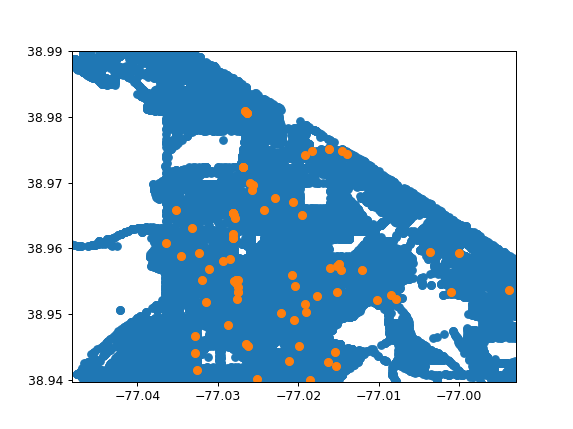

In [60]:
plt.figure(8)
plt.scatter(L_full['gpsX_CR'], L_full['gpsY_CR'])
plt.scatter(L_yesCR_dup_only['gpsX_left'], L_yesCR_dup_only['gpsY_left'])


To explore this idea we start by simply plotting the light outages that are matched to multiple crimes above the full light outage data.  As we can see below, intresting clustering of the multiple crimes outages appear.

<IPython.core.display.Javascript object>


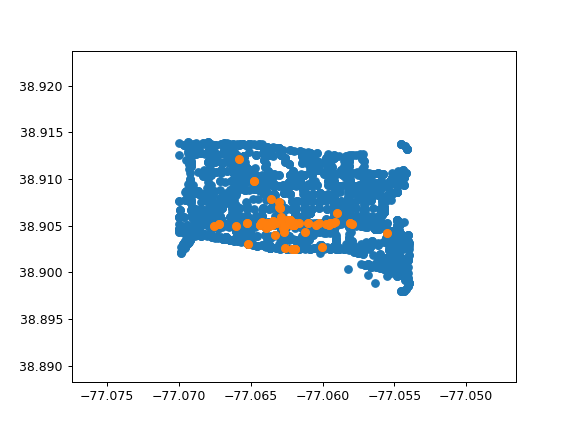

In [59]:
plt.figure(9)
mask1 = (L_full['gpsX_CR'] >= -77.070) & (L_full['gpsX_CR'] <= -77.054) & (L_full['gpsY_CR'] >= 38.898) & (L_full['gpsY_CR'] <= 38.914)
mask2 = (L_yesCR_dup_only['gpsX_left'] >= -77.070) & (L_yesCR_dup_only['gpsX_left'] <= -77.054) & (L_yesCR_dup_only['gpsY_left'] >= 38.898) & (L_yesCR_dup_only['gpsY_left'] <= 38.914)
plt.scatter(L_full[mask1].gpsX_CR, L_full[mask1].gpsY_CR)
plt.scatter(L_yesCR_dup_only[mask2].gpsX_left, L_yesCR_dup_only[mask2].gpsY_left)

Here is the underpass by the Georgetown Waterfront.

<IPython.core.display.Javascript object>


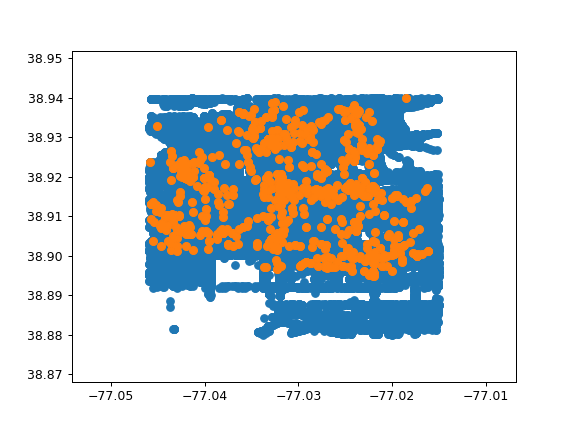

In [58]:
plt.figure(10)
mask1 = (L_full['gpsX_CR'] >= -77.046) & (L_full['gpsX_CR'] <= -77.015) & (L_full['gpsY_CR'] >= 38.88) & (L_full['gpsY_CR'] <= 38.94)
mask2 = (L_yesCR_dup_only['gpsX_left'] >= -77.046) & (L_yesCR_dup_only['gpsX_left'] <= -77.015) & (L_yesCR_dup_only['gpsY_left'] >= 38.88) & (L_yesCR_dup_only['gpsY_left'] <= 38.94)
plt.scatter(L_full[mask1].gpsX_CR, L_full[mask1].gpsY_CR)
plt.scatter(L_yesCR_dup_only[mask2].gpsX_left, L_yesCR_dup_only[mask2].gpsY_left)

Here is inner DC, above the national mall (Chinatown etc.).

When we consider multiple crimes, there is far more non-random patterns that seem to exist.